In [110]:
from utils import save_submission, load_data
import numpy as np
import copy
import matplotlib.pylab as plt
%matplotlib inline
CLASSES = 10

In [4]:
def softmax(Z):
    """
    Convert a set of scores from a linear model into a softmax posterior
    Input:
    Z: N x C array of scores
        Z[n][:] is the set of scores for C classes for the n-th example
    Output:
    S: N x C array
        S[n][:] is the softmax distribution over C classes for the n-th example
    """
    # for 1d inputs
    if Z.ndim == 1:
        Z = Z - np.max(Z)
        return np.exp(Z) / np.sum(np.exp(Z))

    # for matrix inputs
    Z = Z - np.max(Z, axis=1, keepdims=True)
    return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:x 
    X : N x d array (no unit terms)
    model : dictionary containing 'weight' and 'bias'
    Output:
    yhat : N x C array
        yhat[n][:] contains the softmax posterior distribution over C classes for X[n][:]
    """
    return softmax(np.dot(X, model['weight']) + model['bias'])

def test(X, Y, model):
    """
    Compute hard label assignments based on model predictions, and return the accuracy vector
    Input:
    X : N x d array of data (no constant term)
    Y : N x C array with 1-hot encoding of true labels
    model: dictionary 
    Output:
    acc : N array of errors, acc[n] is 1 if correct and 0 otherwise
    """
    return predict(X, model).argmax(-1) == Y.argmax(-1)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    return 1 - test(X, Y, model).mean()

def calc_loss(X, Y, model):
    """
    Evaluate the loss (without regularization penalty), i.e., normalized negative log likelihood
    """
    Z = predict(X, model)
    return -(Y * np.log(Z)).sum() / len(Y)

In [108]:
def calcGrad(X, Y, model):
    """
    Calculate the gradient of the loss w.r.t. model parameters
    Output:
    grad_W : same dimension as model['weight']; gradient w.r.t. the weights
    grad_b : same dimension as model['bias']; gradient w.r.t. the bias terms
    """
    
    grad_W = np.zeros_like(model['weight'], dtype=np.float64)
    grad_b = np.zeros_like(model['bias'], dtype=np.float64)
    
    Z = predict(X, model)
    N = X.shape[0]
    
    # slow and imperative for now
    for x, y, z in zip(X, Y, Z):
        w_grad = (y - z).reshape((1,10))
        x = x.reshape((x.shape[0], 1))
        grad_W -= np.matmul(x, w_grad)
        grad_b += z - y
    
    return grad_W / N, grad_b / N

def modelUpdate(X, Y, model, lambda_, eta):
    """
    Update the model
    Input:
    X, Y : the inputs and 1-hot encoded labels
    model : the currrent model
    lambda : regularization coefficient for L2 penalty
    eta : learning rate
    Output:
    updated model
    """
    grad_W, grad_b = calcGrad(X, Y, model)
    
    model['weight'] -= eta * (grad_W + lambda_ * model['weight'])
    model['bias'] -= eta * grad_b
    
    return model

def runTrainVal(X, Y, model, Xval, Yval, trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    """
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    last_loss = 1e10
    
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]
        bY = Y[shuffled_idx[batch_idx],:]
        cur_loss = calc_loss(bX, bY, model)
        if (iteration % trainopt['display_iter']) == 0:
            print('{:8} batch loss: {:.3f}'.format(iteration, cur_loss))
        model = modelUpdate(bX, bY, model, trainopt['lambda'], eta)
        
        # early stopping criterion
        if abs(cur_loss - last_loss) < 1e-3: break
        last_loss = cur_loss
        
        start_idx = stop_idx % N
        
    # compute train and val error; multiply by 100 for readability (make it percentage points)
    trainError = 100 * error_rate(X, Y, model)
    valError = 100 * error_rate(Xval, Yval, model)
    
    return model, valError, trainError

In [98]:
data_fn = "nmnist.h5"
Xsmall, Ysmall = load_data(data_fn, "small_train")
Xlarge, Ylarge = load_data(data_fn, "large_train")
Xval, Yval = load_data(data_fn, "val")

In [99]:
'''
Observations:

With small data sets:
- More prone to overfitting and the datasets tend to be "noisier", thus regularization
    is more important to force the model to make generalizations rather than overfit.
    Slightly larger regularization values tend to fare better.
    
- Results tend to converge more quickly because there is less data to process. It becomes
    more feasible to make batch size the entire dataset (taking out the S in SGD)
    and obtain better results that way. It may also become necessary to integrate
    early stopping techniques once each iteration starts to not improve loss very much.
    
With large data sets:
- We need to carefully find a batch size that balances between efficiency and accuracy.
    Choosing a batch size that is too small (like 1-10) does not lead to good results.
    
- Because the datasets is much larger, it serves as a better proxy of the population.
    Slightly smaller lambda values (0.01, 0.05) do better, and in decreasing the 
    training error significantly often results in a decrease in validation error.
    However, there is clearly a happy medium as it is still possible to overfit.
    
- We tend to want to decrease the etadrop factor to prevent the model from getting 
    stuck in local optima for a large number of iterations. Sometimes, the early stopping
    criterion we implement (which stops training when loss doesn't change by more than 1e-3)
    is hit too early.
'''

# generalized tuning
# allows us to set any number of hyperparameter values

def tune(features, feature_values, trainopt, model):
    models = {}
    for feature_value in feature_values:
        for key, val in zip(features, feature_value):
            trainopt[key] = val
        trained_model, valErr, trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
        models[feature_value] = {'model': trained_model, 'val_err': valErr, 'train_err': trainErr}
        print(f'{features}: {feature_value}, train error: {trainErr:.2f}, value error: {valErr:.2f}')
    return models

trainopt = {
    'eta': 0.5,
    'maxiter': 1000,
    'display_iter': 100,
    'batch_size': 7000,  
    'etadrop': .33,
    'eta_frac': .2
}

NFEATURES = Xsmall.shape[1]
seed = np.random.RandomState(2341)
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES))
model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

# various tests ran:

# test different batch sizes
# results = tune('batch_size', [1000, 64, 10, 1], trainopt, copy.deepcopy(model))

# test different learning rates
# results = tune(['eta', 'etadrop'], [(2, 0.75), (1, 0.5)], trainopt, copy.deepcopy(model))

# test different eta drops
# results = tune(['etadrop', 'eta_frac'], [(0.75, 0.4), (0.5, 0.2), (0.1, 0.2), (0.1, 0.1)], trainopt, copy.deepcopy(model))

# test different batch sizes
# results = tune(['maxiter', 'batch_size', 'lambda'], [(1000, 400, 0.005)], trainopt, copy.deepcopy(model))

In [109]:
# FINAL HYPERPARAMETERS
trainopt = {
    'eta': 0.5,
    'maxiter': 1000,
    'display_iter': 100,
    'batch_size': 7000,  
    'etadrop': .33,
    'eta_frac': .2
}

NFEATURES = Xsmall.shape[1]

seed = np.random.RandomState(2341)  # to make sure everyone starts from the same point
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES)) # -- with random seed fixed

model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

lambdas = np.array([0.05])

small_trained_models = dict()
large_trained_models = dict()

# -- small train set: sweep the lambda values
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    trained_model, valErr, trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
    small_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('small train set model: -> lambda = %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
# -- model trained on large train set
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    trained_model, valErr, trainErr = runTrainVal(Xlarge, Ylarge, copy.deepcopy(model), Xval, Yval, trainopt)
    large_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('large train set model: -> lambda = %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
best_small_trained_lambda = 0.
best_small_trained_model = None
best_small_trained_val_err = 100.
for lambda_,results in small_trained_models.items():
    if results['val_err'] < best_small_trained_val_err:
        best_small_trained_val_err = results['val_err']
        best_small_trained_model = results['model']
        best_small_trained_lambda = lambda_
        
best_large_trained_lambda = 0.
best_large_trained_model = None
best_large_trained_val_err = 100.
for lambda_,results in large_trained_models.items():
    if results['val_err'] < best_large_trained_val_err:
        best_large_trained_val_err = results['val_err']
        best_large_trained_model = results['model']
        best_large_trained_lambda = lambda_

print("Best small train model val err:", best_small_trained_val_err)
print("Best small train model lambda:", best_small_trained_lambda)
print("Best large train model val err:", best_large_trained_val_err)
print("Best large train model lambda:", best_large_trained_lambda)

       0 batch loss: 2.304
     100 batch loss: 0.644
small train set model: -> lambda = 0.0500, train error: 1.00, val error: 30.30
       0 batch loss: 2.301
     100 batch loss: 1.077
large train set model: -> lambda = 0.0500, train error: 18.26, val error: 20.15
Best small train model val err: 30.300000000000004
Best small train model lambda: 0.05
Best large train model val err: 20.150000000000002
Best large train model lambda: 0.05


In [111]:
#Generate a Kaggle submission file using `model`

#for model trained on small_train
kaggleX = load_data(data_fn, 'kaggle')
kaggleYhat_small = predict(kaggleX, best_small_trained_model).argmax(-1)
save_submission('submission-small.csv', kaggleYhat_small)

#for model trained on large_train
kaggleYhat_large = predict(kaggleX, best_large_trained_model).argmax(-1)
save_submission('submission-large.csv', kaggleYhat_large)


Saved: submission-small.csv
Saved: submission-large.csv


In [120]:
# create confusion matrices

pred = predict(Xval, best_small_trained_model)
C = np.zeros((10,10), dtype=np.int64)

for i, j in zip(pred.argmax(-1), Yval.argmax(-1)):
    C[i][j] += 1
    
C

array([[157,   0,   6,   6,   1,   9,   4,   4,   3,   3],
       [  0, 215,  35,  15,   4,  16,  13,  13,  26,   6],
       [  3,   1, 117,   9,   3,   5,   5,   0,   5,   4],
       [  1,   0,   8, 104,   0,  24,   0,   1,  11,   3],
       [  1,   1,   5,   0, 142,  16,  12,   3,   4,  15],
       [  3,   0,   1,  11,   3,  63,   4,   1,   2,   0],
       [ 14,   0,   3,   0,   1,   7, 171,   0,   1,   3],
       [  2,   1,   7,   4,   7,   6,   2, 176,   2,  14],
       [  3,   3,  23,  21,   1,  12,   3,   3, 117,   6],
       [  3,   2,   5,  13,  31,  14,   3,  32,  25, 132]])

In [121]:
pred = predict(Xval, best_large_trained_model)
C = np.zeros((10,10), dtype=np.int64)

for i, j in zip(pred.argmax(-1), Yval.argmax(-1)):
    C[i][j] += 1

C

array([[173,   0,   5,   1,   1,   7,   3,   3,   3,   2],
       [  0, 214,  12,   6,   2,   7,   7,  10,  22,   3],
       [  1,   3, 158,   9,   0,   3,   2,   0,   7,   5],
       [  2,   1,   7, 151,   1,  39,   0,   2,  21,   7],
       [  0,   0,   3,   0, 164,   6,   5,   5,   3,  14],
       [  0,   1,   1,   2,   2,  88,   2,   0,   4,   0],
       [  9,   0,   7,   2,   3,   8, 195,   0,   2,   2],
       [  0,   2,   4,   5,   6,   5,   0, 198,   0,  23],
       [  1,   2,   8,   4,   1,   5,   3,   3, 128,   2],
       [  1,   0,   5,   3,  13,   4,   0,  12,   6, 128]])

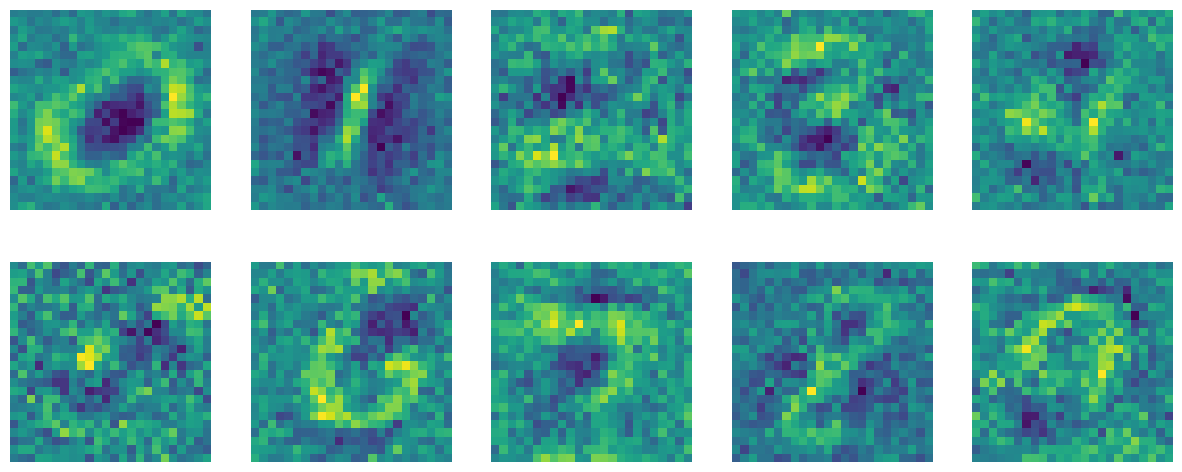

In [131]:
_, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(best_small_trained_model['weight'][:,i].reshape(24,24))
    ax.axis('off')

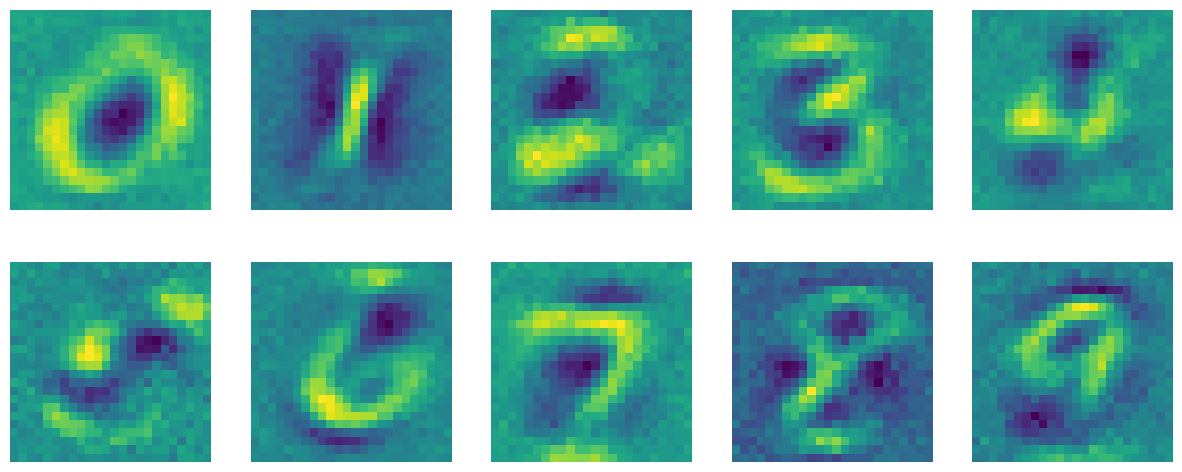

In [132]:
_, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(best_large_trained_model['weight'][:,i].reshape(24,24))
    ax.axis('off')